# car model

Let's start with some basic modeling, now that we actually have some data out of the way.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from birdcall_distribution.geo import (
    get_shape_us_state,
    generate_grid,
    add_lonlat_columns,
    generate_grid_adjaceny_list,
    CA_EXTENT,
    get_adjacency_mapping,
    convert_to_adjacency_matrix,
)

ee_df = pd.read_parquet("../data/earth_engine_v2.parquet")
grid_size = ee_df.grid_size.values[0]
ca_shape = get_shape_us_state("California")
grid = generate_grid(ca_shape, CA_EXTENT, (grid_size, grid_size))
adjacency_list = generate_grid_adjaceny_list(grid)
mapping = get_adjacency_mapping(adjacency_list)
W = convert_to_adjacency_matrix(adjacency_list)

In [3]:
from birdcall_distribution.utils import convert_time

df = pd.read_csv("../data/raw/birdclef-2022/train_metadata.csv")
df["hour"] = df.time.apply(convert_time)
df = df[["primary_label", "latitude", "longitude", "hour"]].dropna()
df = add_lonlat_columns(df, grid)
df = df[df.grid.notnull()]
df["adjacency_idx"] = df.grid_id.apply(lambda x: mapping.get(x, None))
df

,primary_label,latitude,longitude,hour,grid_id,grid,adjacency_idx
51,amewig,35.0307,-120.6205,9.500000,-121.25_35.0,"POLYGON ((-121.25 35, -120.5 35, -120.5 35.75,...",65
56,amewig,32.5640,-117.1256,9.900000,-117.5_32.0,"POLYGON ((-117.5 32, -116.75 32, -116.75 32.75...",21
57,amewig,32.5640,-117.1256,10.250000,-117.5_32.0,"POLYGON ((-117.5 32, -116.75 32, -116.75 32.75...",21
58,amewig,32.5640,-117.1256,10.883333,-117.5_32.0,"POLYGON ((-117.5 32, -116.75 32, -116.75 32.75...",21
59,amewig,32.5640,-117.1256,10.750000,-117.5_32.0,"POLYGON ((-117.5 32, -116.75 32, -116.75 32.75...",21
...,...,...,...,...,...,...,...
14652,wiltur,33.1349,-116.8522,10.850000,-117.5_32.75,"POLYGON ((-117.5 32.75, -116.75 32.75, -116.75...",22
14655,wiltur,35.2530,-120.8760,14.016667,-121.25_35.0,"POLYGON ((-121.25 35, -120.5 35, -120.5 35.75,...",65
14656,wiltur,32.8706,-116.4247,5.450000,-116.75_32.75,"POLYGON ((-116.75 32.75, -116 32.75, -116 33.5...",15
14660,wiltur,38.5321,-121.0686,5.633333,-121.25_38.0,"POLYGON ((-121.25 38, -120.5 38, -120.5 38.75,...",69


In [4]:
# create counts for each adjacency index
import numpy as np
import pymc as pm
import arviz as az

In [167]:
from birdcall_distribution.plot import dataframe_color_getter, plot_grid
from functools import partial
import matplotlib.pyplot as plt


def plot_ppc(prep_df, ppc, prop="log_pred"):
    pred = ppc.posterior_predictive.y.values.mean(axis=(0, 1))
    pred_df = pd.DataFrame({"pred": pred})
    pred_df["adjacency_idx"] = pred_df.index
    pred_df = pred_df.set_index("adjacency_idx").join(prep_df[["grid_id"]])
    # log prediction
    pred_df["log_pred"] = np.log(pred_df.pred)

    plt.hist(pred_df[prop], bins=20)
    plt.show()

    # plot the posterior predictive
    plot_grid(
        ca_shape,
        CA_EXTENT,
        grid,
        color_callback=partial(dataframe_color_getter, pred_df, "grid_id", prop),
        vmin=pred_df[prop].min(),
        vmax=pred_df[prop].max(),
        draw_gridline=False,
    )

    plt.title("California Bird Observations prediction")
    plt.show()

In [5]:
from sklearn.preprocessing import StandardScaler

# count number of observed calls per adjacency index, and join against the ee variables
counts_df = df.grid_id.value_counts().reset_index()
counts_df.columns = ["grid_id", "y"]
prep_df = counts_df.merge(
    ee_df.rename(columns={"name": "grid_id"}), on="grid_id", how="outer"
)
prep_df["adjacency_idx"] = prep_df.grid_id.apply(lambda x: mapping.get(x, None))
prep_df = prep_df.set_index("adjacency_idx").sort_index()
prep_df

,grid_id,y,grid_size,total_pixels,elevation_mean,elevation_min,elevation_max,day_temp_mean,day_temp_min,day_temp_max,...,land_cover_08,land_cover_09,land_cover_10,land_cover_11,land_cover_12,land_cover_13,land_cover_14,land_cover_15,land_cover_16,land_cover_17
adjacency_idx,,,,,,,,,,,,,,,,,,,,,
0,-114.5_32.75,4.0,0.75,5799,360.635686,42,1264,38.250063,28.135905,44.101721,...,0.000172,0.000860,0.053473,0.000516,0.019257,0.001204,0.000172,0.000172,0.245873,0.000688
1,-114.5_33.5,4.0,0.75,5810,332.958333,83,1060,38.373284,29.505644,42.446203,...,0.000172,0.000343,0.020079,0.000172,0.053887,0.002917,0.000172,0.000172,0.561009,0.000172
2,-114.5_34.25,15.0,0.75,5660,651.198508,125,2133,35.820667,21.121678,41.516905,...,0.000176,0.003523,0.046503,0.000176,0.000176,0.007574,0.000176,0.000176,0.147261,0.005461
3,-115.25_32.0,14.0,0.75,5797,27.443632,0,153,38.673146,28.443913,44.966025,...,0.000172,0.001204,0.024596,0.000172,0.394737,0.012900,0.000172,0.000172,0.466976,0.000688
4,-115.25_32.75,9.0,0.75,5795,212.048048,9,871,38.502550,31.003916,42.807535,...,0.000172,0.001893,0.041638,0.000172,0.041466,0.001721,0.000172,0.000172,0.755678,0.000344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,-124.25_40.25,24.0,0.75,5235,555.130669,-3,1749,18.493839,12.968095,25.919888,...,0.091584,0.015232,0.042079,0.003237,0.001523,0.009711,0.000190,0.000190,0.000571,0.045887
104,-124.25_41.0,NaN,0.75,5054,523.124211,0,1760,17.261679,10.346703,23.541750,...,0.016565,0.000986,0.002366,0.002761,0.000197,0.000789,0.000197,0.000197,0.000197,0.157365
105,-124.25_41.75,NaN,0.75,5135,685.691752,-3,2002,19.949706,11.934333,27.914494,...,0.067935,0.006599,0.014752,0.000194,0.000776,0.002329,0.000194,0.000194,0.000194,0.019992


## poisson urban landcover model

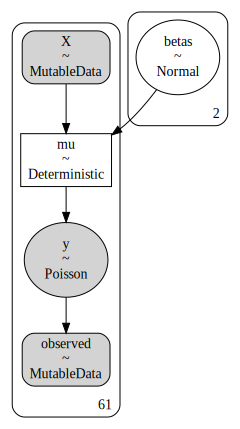

In [132]:
data_cols = [col for col in prep_df.columns[4:]]
scaler = StandardScaler()
scaler.fit(prep_df[data_cols])
scaled_data_df = pd.DataFrame(scaler.transform(prep_df[data_cols]), columns=data_cols)

model_df = prep_df[prep_df.y.notnull()]

with pm.Model() as urban_model:
    # create a masked array with observed counts
    observed = pm.MutableData("observed", model_df.y.values)
    X = pm.MutableData("X", scaled_data_df[prep_df.y.notnull()].land_cover_13.values)
    betas = pm.Normal("betas", mu=0, tau=1e-4, shape=2)

    mu = pm.Deterministic("mu", pm.math.exp(betas[0] + betas[1] * X))
    pm.Poisson("y", mu=mu, observed=observed)

# draw the model via graphviz
pm.model_to_graphviz(urban_model)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
INFO:pymc:Multiprocess sampling (8 chains in 8 jobs)
NUTS: [betas]
INFO:pymc:NUTS: [betas]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
INFO:pymc:Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],2.441,0.038,2.371,2.513,0.001,0.0,4642.0,4619.0,1.0
betas[1],0.208,0.018,0.174,0.240,0.000,0.0,5613.0,5194.0,1.0


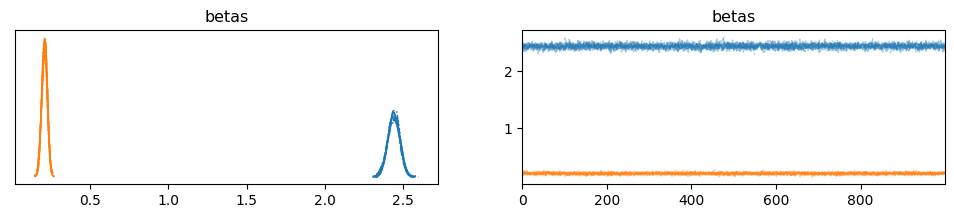

In [133]:
with urban_model:
    trace = pm.sample(cores=8, target_accept=0.9)

az.plot_trace(trace, var_names=["betas"])
az.summary(trace, var_names=["betas"])

Sampling: [y]
INFO:pymc:Sampling: [y]


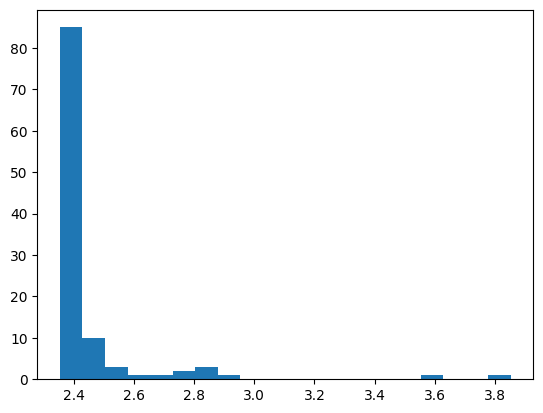

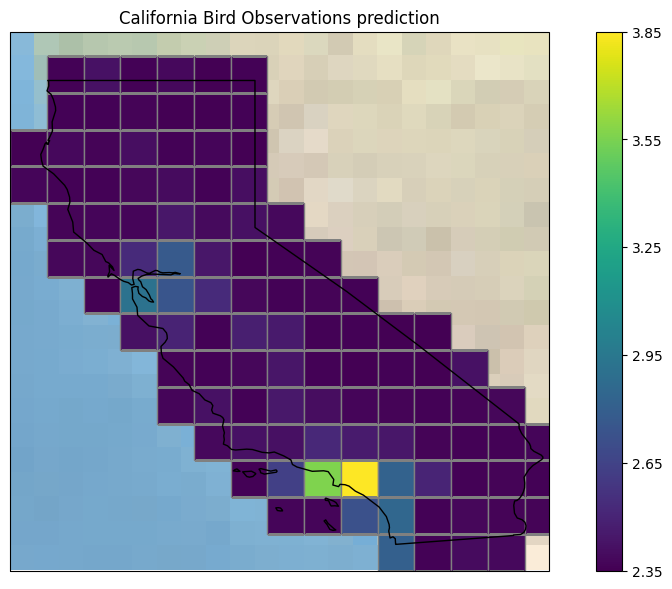

In [136]:
with urban_model:
    pm.set_data(
        {"X": scaled_data_df.land_cover_13.values, "observed": prep_df.y.values}
    )
    ppc = pm.sample_posterior_predictive(trace)

plot_ppc(prep_df, ppc)

## poisson urban landcover (vector) model

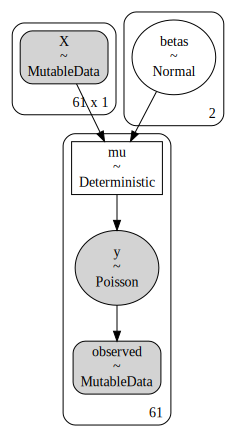

In [137]:
data_cols = [col for col in prep_df.columns if "land_cover_13" in col]
scaler = StandardScaler()
scaler.fit(prep_df[data_cols])
scaled_data_df = pd.DataFrame(scaler.transform(prep_df[data_cols]), columns=data_cols)

model_df = prep_df[prep_df.y.notnull()]

with pm.Model() as vector_urban_model:
    # create a masked array with observed counts
    observed = pm.MutableData("observed", model_df.y.values)
    X = pm.MutableData("X", scaled_data_df[prep_df.y.notnull()])

    betas = pm.Normal("betas", mu=0, tau=1e-4, shape=X.shape[1] + 1)

    mu = pm.Deterministic(
        "mu", pm.math.clip(pm.math.exp(betas[0] + pm.math.dot(X, betas[1:])), 0, 1e3)
    )
    pm.Poisson("y", mu=mu, observed=observed)

# draw the model via graphviz
pm.model_to_graphviz(vector_urban_model)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
INFO:pymc:Multiprocess sampling (16 chains in 16 jobs)
NUTS: [betas]
INFO:pymc:NUTS: [betas]


Sampling 16 chains for 1_000 tune and 5_000 draw iterations (16_000 + 80_000 draws total) took 9 seconds.
INFO:pymc:Sampling 16 chains for 1_000 tune and 5_000 draw iterations (16_000 + 80_000 draws total) took 9 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],2.442,0.038,2.370,2.514,0.0,0.0,66452.0,56625.0,1.0
betas[1],0.208,0.018,0.175,0.242,0.0,0.0,65423.0,57063.0,1.0


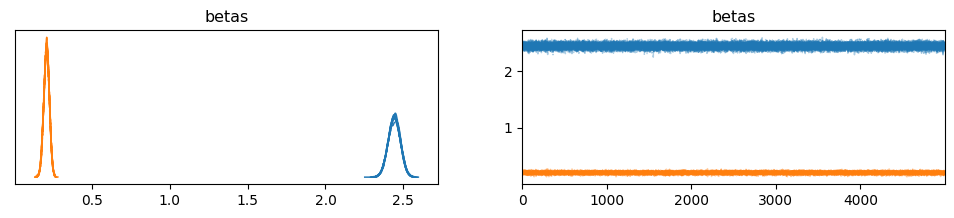

In [138]:
with vector_urban_model:
    trace = pm.sample(5_000, cores=16)

az.plot_trace(trace, var_names=["betas"])
az.summary(trace, var_names=["betas"])

Sampling: [betas, y]
INFO:pymc:Sampling: [betas, y]


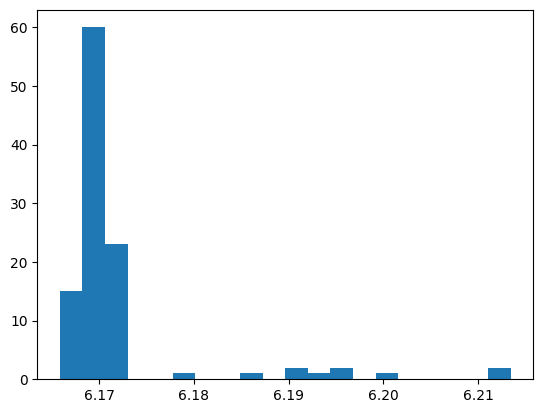

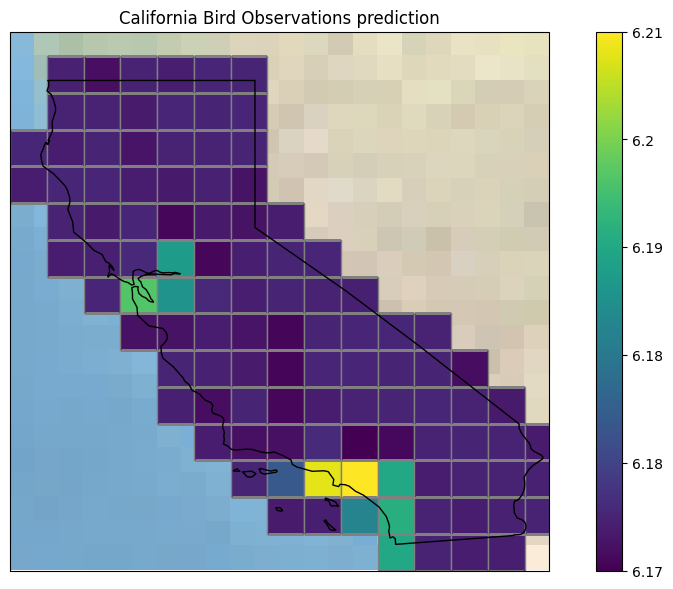

In [140]:
with vector_urban_model:
    pm.set_data({"X": scaled_data_df, "observed": prep_df.y.values})
    ppc = pm.sample_posterior_predictive(trace)

plot_ppc(prep_df, ppc)

## poisson regression with temperature and elevation

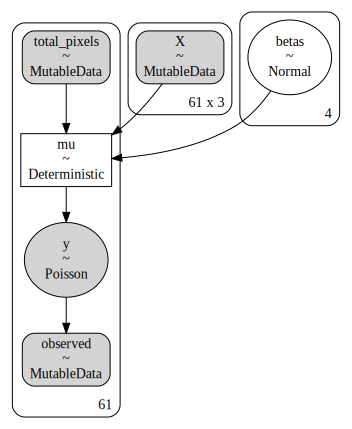

In [146]:
data_cols = [col for col in prep_df.columns if "mean" in col]
scaler = StandardScaler()
scaler.fit(prep_df[data_cols])
scaled_data_df = pd.DataFrame(scaler.transform(prep_df[data_cols]), columns=data_cols)

model_df = prep_df[prep_df.y.notnull()]

with pm.Model() as temp_model:
    # create a masked array with observed counts
    observed = pm.MutableData("observed", model_df.y.values)
    X = pm.MutableData("X", scaled_data_df[prep_df.y.notnull()])
    # we also add total pixels as a spatial correction term
    total_pixels = pm.MutableData("total_pixels", model_df.total_pixels.values)

    betas = pm.Normal("betas", mu=0, tau=1e-3, shape=X.shape[1] + 1)

    mu = pm.Deterministic(
        "mu",
        pm.math.clip(
            pm.math.exp(betas[0] + pm.math.dot(X, betas[1:]))
            + pm.math.log(total_pixels),
            0,
            1e3,
        ),
    )
    pm.Poisson("y", mu=mu, observed=observed)

# draw the model via graphviz
pm.model_to_graphviz(temp_model)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
INFO:pymc:Multiprocess sampling (16 chains in 16 jobs)
NUTS: [betas]
INFO:pymc:NUTS: [betas]


Sampling 16 chains for 1_000 tune and 5_000 draw iterations (16_000 + 80_000 draws total) took 20 seconds.
INFO:pymc:Sampling 16 chains for 1_000 tune and 5_000 draw iterations (16_000 + 80_000 draws total) took 20 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],-1.790,0.469,-2.669,-0.926,0.003,0.002,25893.0,29099.0,1.0
betas[1],-4.021,0.403,-4.788,-3.286,0.002,0.002,27600.0,29831.0,1.0
betas[2],0.374,0.186,0.029,0.732,0.001,0.001,28287.0,30881.0,1.0
betas[3],0.408,0.238,-0.043,0.854,0.001,0.001,27078.0,30791.0,1.0


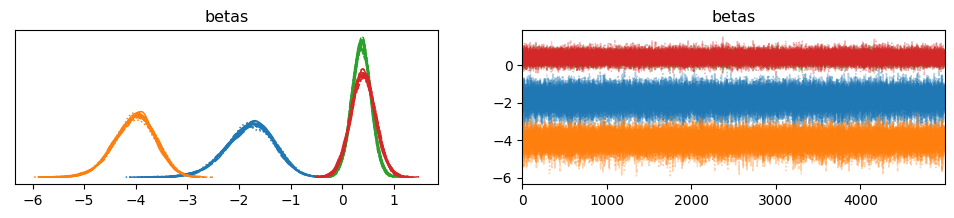

In [147]:
with temp_model:
    trace = pm.sample(5_000, cores=16)

az.plot_trace(trace, var_names=["betas"])
az.summary(trace, var_names=["betas"])

Sampling: [betas, y]
INFO:pymc:Sampling: [betas, y]


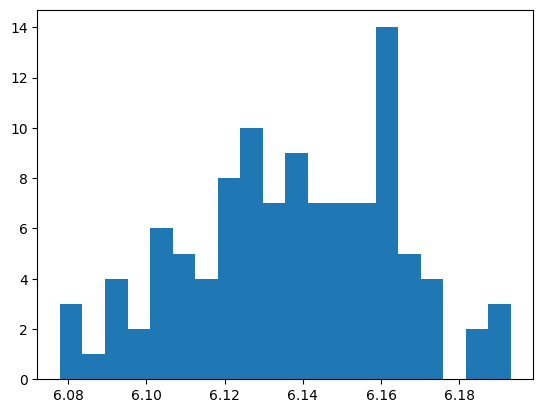

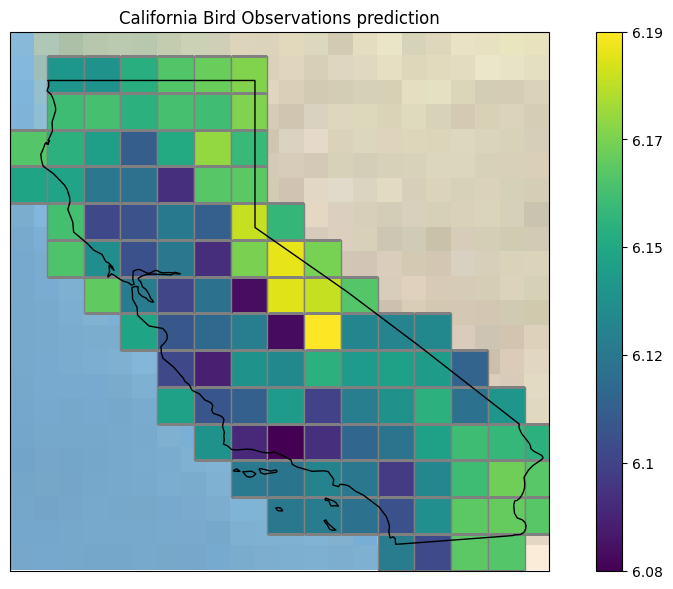

In [149]:
with temp_model:
    pm.set_data(
        {
            "X": scaled_data_df,
            "total_pixels": prep_df.total_pixels.values,
            "observed": prep_df.y.values,
        }
    )
    ppc = pm.sample_posterior_predictive(trace)

plot_ppc(prep_df, ppc)

## poisson regression with correction term (pixels)

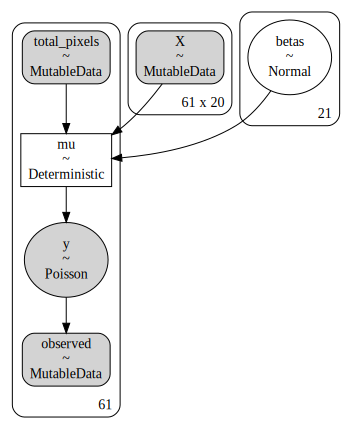

In [141]:
data_cols = [col for col in prep_df.columns if "mean" in col or "land_cover" in col]
scaler = StandardScaler()
scaler.fit(prep_df[data_cols])
scaled_data_df = pd.DataFrame(scaler.transform(prep_df[data_cols]), columns=data_cols)

model_df = prep_df[prep_df.y.notnull()]

with pm.Model() as multiple_regression:
    # create a masked array with observed counts
    observed = pm.MutableData("observed", model_df.y.values)
    X = pm.MutableData("X", scaled_data_df[prep_df.y.notnull()])
    # we also add total pixels as a spatial correction term
    total_pixels = pm.MutableData("total_pixels", model_df.total_pixels.values)

    betas = pm.Normal("betas", mu=0, tau=1e-3, shape=X.shape[1] + 1)

    mu = pm.Deterministic(
        "mu",
        pm.math.clip(
            pm.math.exp(betas[0] + pm.math.dot(X, betas[1:]))
            + pm.math.log(total_pixels),
            0,
            1e3,
        ),
    )
    pm.Poisson("y", mu=mu, observed=observed)

# draw the model via graphviz
pm.model_to_graphviz(multiple_regression)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
INFO:pymc:Multiprocess sampling (16 chains in 16 jobs)
NUTS: [betas]
INFO:pymc:NUTS: [betas]


Sampling 16 chains for 1_000 tune and 5_000 draw iterations (16_000 + 80_000 draws total) took 488 seconds.
INFO:pymc:Sampling 16 chains for 1_000 tune and 5_000 draw iterations (16_000 + 80_000 draws total) took 488 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],-55.843,13.651,-81.341,-31.384,0.799,0.585,324.0,683.0,1.03
betas[1],-22.063,11.007,-43.471,-4.144,0.580,0.410,418.0,834.0,1.03
betas[2],7.172,15.425,-23.486,36.309,0.720,0.509,734.0,296.0,1.02
betas[3],-6.742,11.303,-26.319,17.879,1.456,1.034,74.0,95.0,1.14
betas[4],15.534,17.163,-15.627,48.624,0.561,0.397,824.0,3736.0,1.02
betas[5],-7.580,10.257,-27.364,9.980,0.587,0.416,327.0,667.0,1.03
betas[6],-46.985,29.305,-99.942,10.821,2.672,1.894,127.0,221.0,1.08
betas[7],-22.633,12.101,-48.047,-1.103,0.495,0.350,521.0,179.0,1.03
betas[8],22.068,14.831,-4.089,51.869,2.059,1.717,75.0,42.0,1.13
betas[9],-1.651,3.345,-8.174,4.503,0.190,0.134,318.0,682.0,1.04


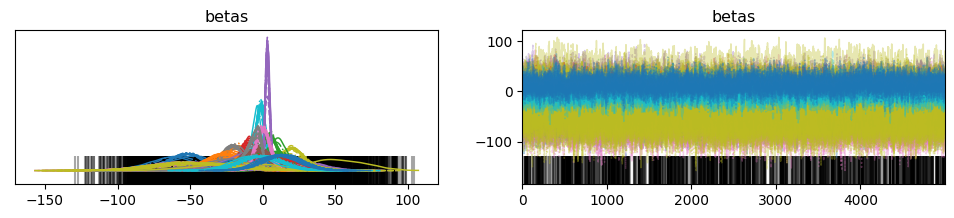

In [142]:
# 5_000 samples at 16 cores takes about 8 minutes, total of 96000 samples
with multiple_regression:
    trace = pm.sample(5_000, cores=16)

az.plot_trace(trace, var_names=["betas"])
az.summary(trace, var_names=["betas"])

Sampling: [betas, y]
INFO:pymc:Sampling: [betas, y]


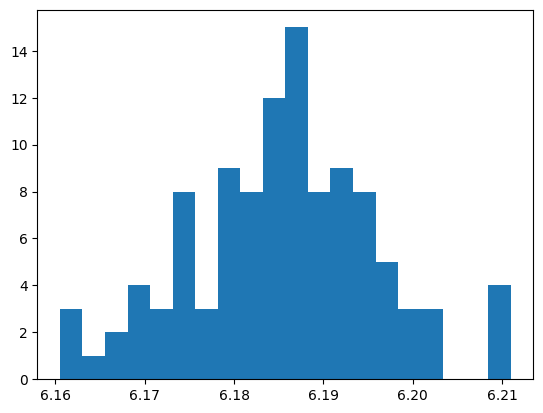

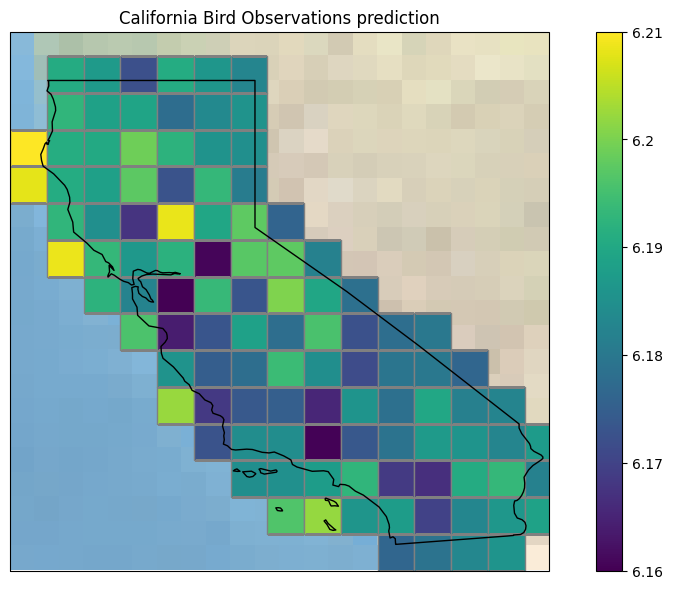

In [145]:
with multiple_regression:
    pm.set_data(
        {
            "X": scaled_data_df,
            "total_pixels": prep_df.total_pixels.values,
            "observed": prep_df.y.values,
        }
    )
    ppc = pm.sample_posterior_predictive(trace)

plot_ppc(prep_df, ppc)

## simple car model

This model should literally just smooth out counts across the region

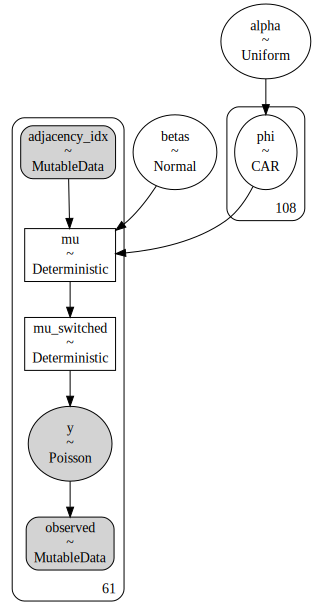

In [178]:
model_df = prep_df[prep_df.y.notnull()]


with pm.Model() as simple_car_model:
    observed = pm.MutableData("observed", model_df.y.values)
    adjacency_idx = pm.MutableData("adjacency_idx", model_df.index.values)
    betas = pm.Normal("betas", mu=0, tau=1e-4)

    # spatial adjustments, random effects
    alpha = pm.Uniform("alpha", 0, 1)
    phi = pm.CAR("phi", mu=np.zeros(W.shape[0]), tau=1e-2, alpha=alpha, W=W)

    mu = pm.Deterministic(
        "mu",
        pm.math.exp(betas + phi[adjacency_idx]),
    )
    # set the mean close to 0 if the mean tends toward infinity
    threshold = 1e3
    mu_switched = pm.Deterministic(
        "mu_switched",
        pm.math.switch(mu > threshold, 0, mu),
    )

    pm.Poisson("y", mu=mu_switched, observed=observed)

# draw the model via graphviz
pm.model_to_graphviz(simple_car_model)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
INFO:pymc:Multiprocess sampling (16 chains in 16 jobs)
NUTS: [betas, alpha, phi]
INFO:pymc:NUTS: [betas, alpha, phi]


Sampling 16 chains for 1_000 tune and 1_000 draw iterations (16_000 + 16_000 draws total) took 18 seconds.
INFO:pymc:Sampling 16 chains for 1_000 tune and 1_000 draw iterations (16_000 + 16_000 draws total) took 18 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas,1.333,0.609,0.190,2.464,0.033,0.023,336.0,778.0,1.05
phi[0],-0.073,0.802,-1.591,1.432,0.033,0.023,589.0,1584.0,1.03
phi[1],-0.069,0.806,-1.588,1.407,0.033,0.023,597.0,1385.0,1.03
phi[2],1.339,0.661,0.153,2.627,0.033,0.023,402.0,981.0,1.04
phi[3],1.266,0.666,0.001,2.497,0.033,0.024,397.0,1012.0,1.04
...,...,...,...,...,...,...,...,...,...
phi[104],-0.005,4.148,-7.875,7.781,0.033,0.033,15773.0,12205.0,1.00
phi[105],-0.094,5.815,-10.669,11.089,0.044,0.046,17382.0,11633.0,1.00
phi[106],-0.187,5.012,-9.512,9.220,0.037,0.041,18816.0,11755.0,1.00
phi[107],-0.887,0.995,-2.852,0.885,0.031,0.022,962.0,2190.0,1.02


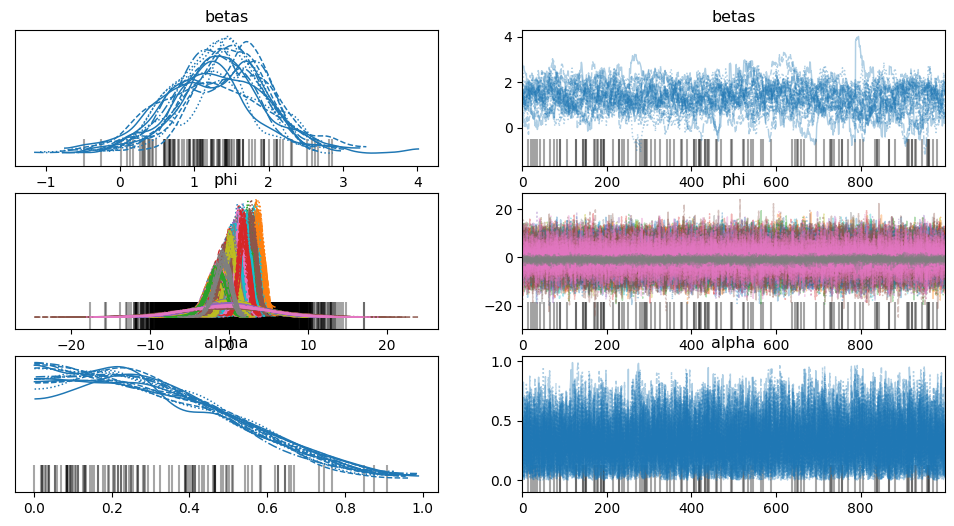

In [179]:
with simple_car_model:
    trace = pm.sample(cores=16)

az.plot_trace(trace, var_names=["betas", "phi", "alpha"])
az.summary(trace, var_names=["betas", "phi", "alpha"])

Sampling: [y]
INFO:pymc:Sampling: [y]


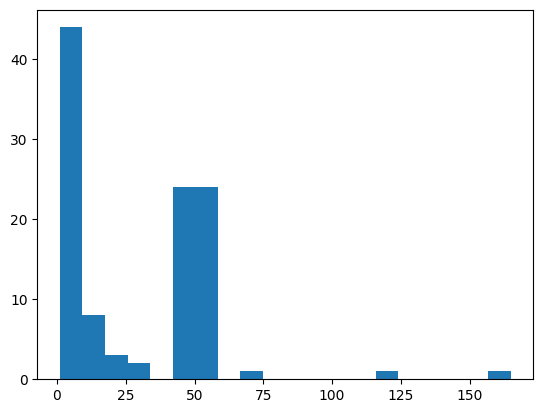

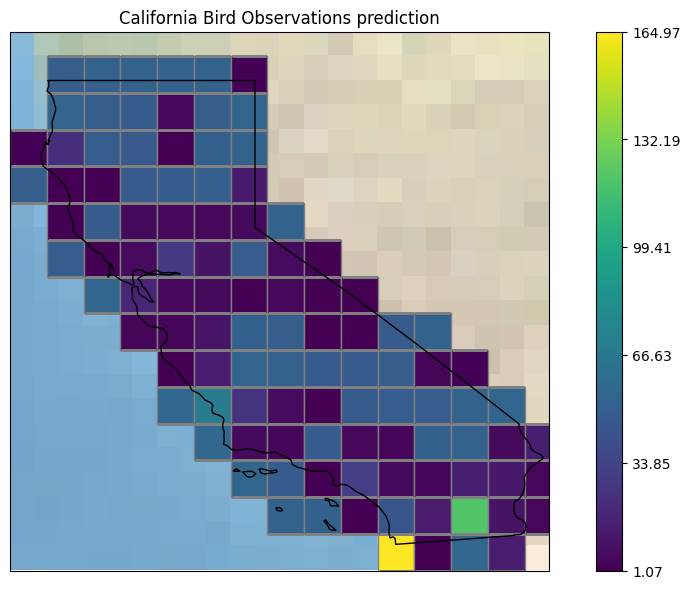

In [180]:
with simple_car_model:
    pm.set_data(
        {
            "adjacency_idx": prep_df.index.values,
            "observed": prep_df.y.values,
        }
    )
    ppc = pm.sample_posterior_predictive(trace)

plot_ppc(prep_df, ppc, "pred")

## temp car model

We piggyback on the temperature/elevation model because it doesn't introduce a large number factors.

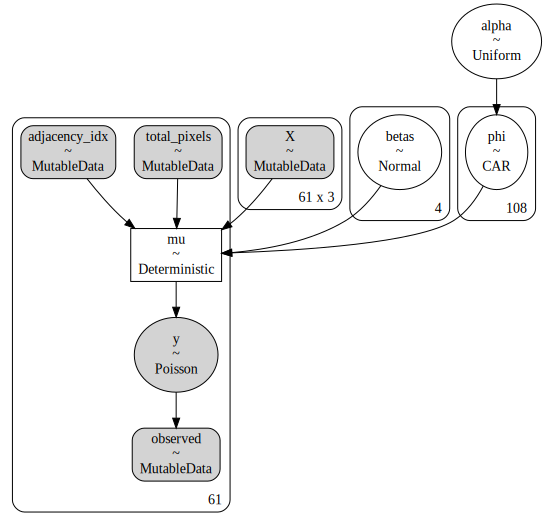

In [151]:
data_cols = [col for col in prep_df.columns if "mean" in col]
scaler = StandardScaler()
scaler.fit(prep_df[data_cols])
scaled_data_df = pd.DataFrame(scaler.transform(prep_df[data_cols]), columns=data_cols)

model_df = prep_df[prep_df.y.notnull()]


with pm.Model() as car_model:
    observed = pm.MutableData("observed", model_df.y.values)
    adjacency_idx = pm.MutableData("adjacency_idx", model_df.index.values)
    total_pixels = pm.MutableData("total_pixels", model_df.total_pixels.values)
    X = pm.MutableData("X", scaled_data_df[prep_df.y.notnull()])

    betas = pm.Normal("betas", mu=0, tau=1e-4, shape=X.shape[1] + 1)

    # spatial adjustments, random effects
    alpha = pm.Uniform("alpha", 0, 1)
    phi = pm.CAR("phi", mu=np.zeros(W.shape[0]), tau=1e-4, alpha=alpha, W=W)

    mu = pm.Deterministic(
        "mu",
        pm.math.clip(
            pm.math.exp(
                betas[0]
                + pm.math.dot(X, betas[1:])
                + phi[adjacency_idx]
                + pm.math.log(total_pixels)
            ),
            0,
            1e3,
        ),
    )

    pm.Poisson("y", mu=mu, observed=observed)

# draw the model via graphviz
pm.model_to_graphviz(car_model)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
INFO:pymc:Multiprocess sampling (16 chains in 16 jobs)
NUTS: [betas, alpha, phi]
INFO:pymc:NUTS: [betas, alpha, phi]


Sampling 16 chains for 1_000 tune and 5_000 draw iterations (16_000 + 80_000 draws total) took 893 seconds.
INFO:pymc:Sampling 16 chains for 1_000 tune and 5_000 draw iterations (16_000 + 80_000 draws total) took 893 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],-6.896,5.862,-17.854,3.792,0.232,0.164,645.0,1741.0,1.03
betas[1],0.096,8.628,-16.347,15.508,0.564,0.399,237.0,2305.0,1.05
betas[2],-0.670,10.089,-19.509,18.313,0.434,0.307,552.0,1417.0,1.04
betas[3],0.888,12.761,-23.628,23.830,0.680,0.481,366.0,2119.0,1.04
phi[0],-0.893,11.516,-21.989,21.937,0.340,0.240,1120.0,3206.0,1.03
...,...,...,...,...,...,...,...,...,...
phi[104],2.389,42.384,-76.109,82.805,2.393,1.693,316.0,372.0,1.03
phi[105],-0.094,57.491,-110.139,106.629,1.085,0.768,2803.0,32375.0,1.01
phi[106],-5.126,52.917,-106.113,90.418,4.552,3.225,137.0,204.0,1.07
phi[107],-0.110,15.374,-28.927,29.764,0.402,0.361,1451.0,2942.0,1.08


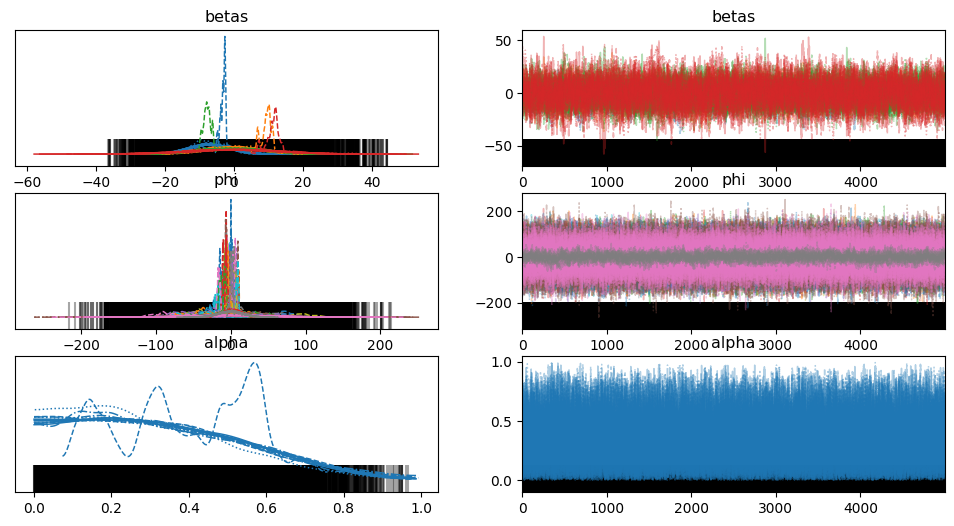

In [152]:
with car_model:
    trace = pm.sample(5_000, cores=16)

az.plot_trace(trace, var_names=["betas", "phi", "alpha"])
az.summary(trace, var_names=["betas", "phi", "alpha"])

Sampling: [betas, y]
INFO:pymc:Sampling: [betas, y]


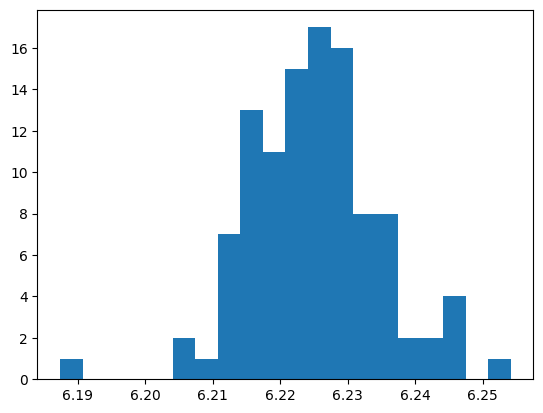

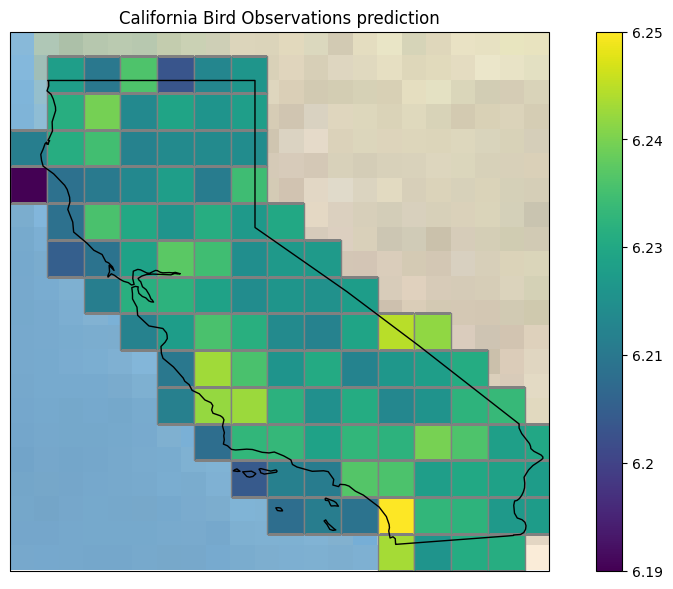

In [153]:
with car_model:
    pm.set_data(
        {
            "X": scaled_data_df,
            "total_pixels": prep_df.total_pixels.values,
            "adjacency_idx": prep_df.index.values,
            "observed": prep_df.y.values,
        }
    )
    ppc = pm.sample_posterior_predictive(trace)

plot_ppc(prep_df, ppc)